# Análisis de la NBA — 2010–2015

In [1]:
from pathlib import Path
import sqlite3
import pandas as pd

In [2]:
DB_PATH = Path("nba.sqlite")  

# Establecer conexión
con = sqlite3.connect(DB_PATH)
print("Conexión establecida con:", DB_PATH)

Conexión establecida con: nba.sqlite


In [10]:
# --- Paso 1: Conexión persistente ---
DB_PATH = Path("nba.sqlite")

if not DB_PATH.exists():
    raise FileNotFoundError(f"No se encontró el archivo en {DB_PATH}")

con = sqlite3.connect(DB_PATH)
print("Conexión activa con:", DB_PATH)

Conexión activa con: nba.sqlite


# Exploración de tablas 

Objetivo: listar todas las tablas disponibles en la base de datos nba.sqlite para identificar con cuáles trabajaremos en el EDA.

In [3]:
con = sqlite3.connect(DB_PATH)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)
con.close()

print("Tablas encontradas:")
display(tables)

Tablas encontradas:


,name
0,game
1,game_summary
2,other_stats
3,officials
4,inactive_players
5,game_info
6,line_score
7,play_by_play
8,player
9,team


# Conteo de filas y columnas por tabla

Objetivo: conocer el tamaño de cada tabla en la base de datos nba.sqlite antes de aplicar filtros.
Esto nos permitirá dimensionar cuántos registros se van a recortar después cuando filtremos por fecha.

In [11]:
# --- Paso 2: Conteo de filas y columnas por tabla (reusa `con`) ---
if 'tables' not in globals():
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)["name"].tolist()

sizes = []
for tbl in tables:
    n_rows = pd.read_sql(f"SELECT COUNT(*) AS cnt FROM {tbl};", con)["cnt"].iat[0]
    n_cols = pd.read_sql(f"PRAGMA table_info({tbl});", con).shape[0]
    sizes.append((tbl, n_rows, n_cols))

df_sizes = pd.DataFrame(sizes, columns=["Tabla", "Filas", "Columnas"]).sort_values("Filas", ascending=False)
display(df_sizes)

,Tabla,Filas,Columnas
7,play_by_play,13592899,34
4,inactive_players,110191,9
3,officials,70971,5
0,game,65698,55
1,game_summary,58110,14
5,game_info,58053,4
6,line_score,58053,43
2,other_stats,28271,26
14,draft_history,8257,14
8,player,4815,5


# Filtro global por fecha + selección de columnas

Objetivo: traer solo los partidos entre 2010-10-01 y 2015-06-30 desde game, y filtrar todas las tablas relacionadas en SQLite usando game_id.

In [14]:
DATE_START = "2010-10-01"
DATE_END   = "2015-06-30"

# ---- utilidades ----
def existing_cols(table):
    return pd.read_sql(f"PRAGMA table_info({table});", con)["name"].tolist()

def select_intersection(table, wanted_cols, where_sql=None, params=None, extra_cols=None):
    cols_exist = set(existing_cols(table))
    keep = [c for c in wanted_cols if c in cols_exist]
    if extra_cols:
        keep += [c for c in extra_cols if c in cols_exist]
    if not keep:
        return pd.DataFrame()
    sel = ", ".join(keep)
    sql = f"SELECT {sel} FROM {table}"
    if where_sql:
        sql += f" WHERE {where_sql}"
    return pd.read_sql(sql, con, params=params)

# ---- columnas deseadas por tabla (de tu lista) ----
COLS_GAME = [
    "game_id","season_id","season_type","game_date",
    "team_id_home","team_id_away","wl_home",
    "fgm_home","fga_home","fg3m_home","fg3a_home","ftm_home","fta_home",
    "fgm_away","fga_away","fg3m_away","fg3a_away","ftm_away","fta_away",
    "oreb_home","dreb_home","reb_home","oreb_away","dreb_away","reb_away",
    "ast_home","stl_home","blk_home","tov_home","pf_home","pts_home",
    "ast_away","stl_away","blk_away","tov_away","pf_away","pts_away"
]

COLS_OTHER_STATS = [
    "game_id","team_id_home","team_id_away",
    "pts_paint_home","pts_paint_away",
    "pts_2nd_chance_home","pts_2nd_chance_away",
    "pts_fb_home","pts_fb_away",
    "lead_changes","times_tied",
    "team_turnovers_home","team_turnovers_away",
    "total_turnovers_home","total_turnovers_away",
    "team_rebounds_home","team_rebounds_away",
    "pts_off_to_home","pts_off_to_away"
]

COLS_LINE_SCORE = [
    "game_id","team_id_home","team_id_away",
    "pts_qtr1_home","pts_qtr2_home","pts_qtr3_home","pts_qtr4_home","pts_home",
    "pts_qtr1_away","pts_qtr2_away","pts_qtr3_away","pts_qtr4_away","pts_away"
]

OT_CANDIDATES = [f"pts_ot{i}_home" for i in range(1,10)] + [f"pts_ot{i}_away" for i in range(1,10)]

COLS_GAME_INFO = ["game_id","game_date","attendance"]

COLS_TEAM = ["id","full_name","abbreviation","city","state"]  

COLS_PLAYER = ["id","full_name"]

COLS_CPI = ["person_id","display_first_last","position","season_exp","height","weight","from_year","to_year"]

# ---- 1) game filtrada por fecha ----
where_game_date = "date(game_date) BETWEEN ? AND ?"
game_f = select_intersection("game", COLS_GAME, where_sql=where_game_date, params=[DATE_START, DATE_END])
print("game_f:", game_f.shape)

# ---- subconjunto de game_id del rango ----
game_ids_sql = """
SELECT game_id FROM game
WHERE date(game_date) BETWEEN ? AND ?
"""

# ---- 2) otras tablas filtradas por game_id del rango ----
other_stats_f = select_intersection(
    "other_stats", COLS_OTHER_STATS,
    where_sql=f"game_id IN ({game_ids_sql})", params=[DATE_START, DATE_END]
)
print("other_stats_f:", other_stats_f.shape)

line_score_f = select_intersection(
    "line_score", COLS_LINE_SCORE,
    where_sql=f"game_id IN ({game_ids_sql})", params=[DATE_START, DATE_END],
    extra_cols=OT_CANDIDATES
)
print("line_score_f:", line_score_f.shape)

game_info_f = select_intersection(
    "game_info", COLS_GAME_INFO,
    where_sql=f"game_id IN ({game_ids_sql})", params=[DATE_START, DATE_END]
)
print("game_info_f:", game_info_f.shape)

# ---- 3) reducir play_by_play al rango; no lo unimos al dataset principal ----
pbp_cols_exist = existing_cols("play_by_play")
PBP_KEEP = [c for c in [
    "game_id","eventnum","eventmsgtype","eventmsgactiontype",
    "period","pctimestring","score","scoremargin",
    "player1_id","player1_team_id","player2_id","player2_team_id","player3_id","player3_team_id"
] if c in pbp_cols_exist]
play_by_play_f = select_intersection(
    "play_by_play", PBP_KEEP,
    where_sql=f"game_id IN ({game_ids_sql})", params=[DATE_START, DATE_END]
)
print("play_by_play_f:", play_by_play_f.shape)

# ---- 4) teams presentes en el rango ----
team_ids_sql = """
SELECT team_id_home AS tid FROM game WHERE date(game_date) BETWEEN ? AND ?
UNION
SELECT team_id_away AS tid FROM game WHERE date(game_date) BETWEEN ? AND ?
"""
teams_f = select_intersection("team", COLS_TEAM, where_sql=f"id IN ({team_ids_sql})",
                              params=[DATE_START, DATE_END, DATE_START, DATE_END])
print("teams_f:", teams_f.shape)

# ---- 5) players presentes en el rango (a partir de play_by_play filtrado) ----
# Si play_by_play no tiene filas, evitamos consulta pesada
if len(play_by_play_f):
    # ids de jugadores vistos en pbp (desde DF para evitar consulta anidada muy larga)
    player_ids = pd.unique(
        pd.concat([
            play_by_play_f.get("player1_id", pd.Series(dtype="Int64")),
            play_by_play_f.get("player2_id", pd.Series(dtype="Int64")),
            play_by_play_f.get("player3_id", pd.Series(dtype="Int64")),
        ], ignore_index=True)
    )
    player_ids = [int(x) for x in player_ids if pd.notna(x)]
    if player_ids:
        # construir cláusula IN segura por chunks
        def read_players_by_ids(ids, chunk=1000):
            dfs = []
            for i in range(0, len(ids), chunk):
                chunk_ids = ids[i:i+chunk]
                placeholders = ",".join(["?"]*len(chunk_ids))
                dfs.append(pd.read_sql(f"SELECT {', '.join([c for c in COLS_PLAYER if c in existing_cols('player')])} "
                                       f"FROM player WHERE id IN ({placeholders})", con, params=chunk_ids))
            return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(columns=COLS_PLAYER)
        players_f = read_players_by_ids(player_ids)
    else:
        players_f = pd.DataFrame(columns=[c for c in COLS_PLAYER if c in existing_cols("player")])
else:
    players_f = pd.DataFrame(columns=[c for c in COLS_PLAYER if c in existing_cols("player")])
print("players_f:", players_f.shape)

# ---- 6) common_player_info reducido a esos players ----
if len(players_f):
    cpi_cols_exist = [c for c in COLS_CPI if c in existing_cols("common_player_info")]
    if cpi_cols_exist:
        placeholders = ",".join(["?"]*len(players_f["id"]))
        cpi_sql = f"SELECT {', '.join(cpi_cols_exist)} FROM common_player_info WHERE person_id IN ({placeholders})"
        common_player_info_f = pd.read_sql(cpi_sql, con, params=players_f["id"].tolist())
    else:
        common_player_info_f = pd.DataFrame()
else:
    common_player_info_f = pd.DataFrame()
print("common_player_info_f:", common_player_info_f.shape)

# ---- vista rápida de shapes ----
shapes = {
    "game_f": game_f.shape,
    "other_stats_f": other_stats_f.shape,
    "line_score_f": line_score_f.shape,
    "game_info_f": game_info_f.shape,
    "teams_f": teams_f.shape,
    "players_f": players_f.shape,
    "play_by_play_f": play_by_play_f.shape,
    "common_player_info_f": common_player_info_f.shape,
}

game_f: (5606, 37)
other_stats_f: (4776, 19)
line_score_f: (5116, 31)
game_info_f: (5116, 3)
play_by_play_f: (2172493, 14)
teams_f: (30, 5)
players_f: (1092, 2)
common_player_info_f: (812, 8)


# Verificación del filtrado por game_id

Objetivo: confirmar que el filtrado se aplicó bien.

In [15]:
# --- Paso 4.1: Verificaciones del filtrado ---
def subset_ok(child_df, child_key, parent_df, parent_key="game_id"):
    child_ids = pd.unique(child_df[child_key].dropna()) if child_key in child_df.columns else []
    parent_ids = set(pd.unique(parent_df[parent_key].dropna()))
    not_in_parent = [gid for gid in child_ids if gid not in parent_ids]
    return len(not_in_parent), not_in_parent[:5]

checks = {}

# 1) subset checks
for name, df in {
    "other_stats_f": other_stats_f,
    "line_score_f": line_score_f,
    "game_info_f": game_info_f,
    "play_by_play_f": play_by_play_f
}.items():
    n_bad, sample = subset_ok(df, "game_id", game_f)
    checks[name] = {"ids_fuera_de_game_f": n_bad, "muestra": sample}

# 2) rango fechas
date_col = "game_date" if "game_date" in game_f.columns else None
min_d = game_f[date_col].min() if date_col else None
max_d = game_f[date_col].max() if date_col else None

# 3) duplicados por game_id
dups = {
    "game_f": int(game_f.duplicated("game_id").sum()) if "game_id" in game_f.columns else None,
    "other_stats_f": int(other_stats_f.duplicated("game_id").sum()) if "game_id" in other_stats_f.columns else None,
    "line_score_f": int(line_score_f.duplicated("game_id").sum()) if "game_id" in line_score_f.columns else None,
    "game_info_f": int(game_info_f.duplicated("game_id").sum()) if "game_id" in game_info_f.columns else None,
}

print("Subset checks (ids fuera de game_f):", checks)
print("Duplicados por game_id:", dups)
print("Rango fechas game_f -> min:", min_d, "| max:", max_d)

Subset checks (ids fuera de game_f): {'other_stats_f': {'ids_fuera_de_game_f': 0, 'muestra': []}, 'line_score_f': {'ids_fuera_de_game_f': 0, 'muestra': []}, 'game_info_f': {'ids_fuera_de_game_f': 0, 'muestra': []}, 'play_by_play_f': {'ids_fuera_de_game_f': 0, 'muestra': []}}
Duplicados por game_id: {'game_f': 3, 'other_stats_f': 3, 'line_score_f': 3, 'game_info_f': 3}
Rango fechas game_f -> min: 2010-10-03 00:00:00 | max: 2015-06-16 00:00:00


# Duplicados por game_id

Objetivo: identificar game_id duplicados en cada tabla y quedarnos con 1 fila por juego para evitar duplicación al unir.

In [16]:
# --- Paso 4.2: resolver duplicados por game_id ---
def dup_report(df, name):
    has_key = "game_id" in df.columns
    dups_n = int(df.duplicated("game_id").sum()) if has_key else 0
    sample_ids = (
        df.loc[df.duplicated("game_id", keep=False), "game_id"].head(10).tolist()
        if dups_n > 0 else []
    )
    before = df.shape
    if has_key and dups_n:
        df = df.drop_duplicates(subset="game_id", keep="first").copy()
    after = df.shape
    print(f"[{name}] dups={dups_n} | before={before} -> after={after} | sample={sample_ids}")
    return df

game_f        = dup_report(game_f,        "game_f")
other_stats_f = dup_report(other_stats_f, "other_stats_f")
line_score_f  = dup_report(line_score_f,  "line_score_f")
game_info_f   = dup_report(game_info_f,   "game_info_f")
# Nota: play_by_play_f puede tener MUCHAS filas por juego; no se deduplica aquí.


[game_f] dups=3 | before=(5606, 37) -> after=(5603, 37) | sample=['0031000001', '0031000001', '0031200001', '0031200001', '0031400001', '0031400001']
[other_stats_f] dups=3 | before=(4776, 19) -> after=(4773, 19) | sample=['0031000001', '0031000001', '0031200001', '0031200001', '0031400001', '0031400001']
[line_score_f] dups=3 | before=(5116, 31) -> after=(5113, 31) | sample=['0031000001', '0031000001', '0031200001', '0031200001', '0031400001', '0031400001']
[game_info_f] dups=3 | before=(5116, 3) -> after=(5113, 3) | sample=['0031000001', '0031000001', '0031200001', '0031200001', '0031400001', '0031400001']


# JOINs por game_id para dataset principal de partidos

Objetivo: unir game_f con other_stats_f, line_score_f y game_info_f por game_id (LEFT), manteniendo 1 fila por partido.

In [17]:
# --- Paso 5: JOINs por game_id (dataset principal por partido) ---

def prep_for_merge(base_df, add_df, key="game_id"):
    """Quita del add_df las columnas que ya existen en base_df (excepto la key)."""
    if add_df is None or add_df.empty:
        return add_df
    keep = [key] + [c for c in add_df.columns if c != key and c not in base_df.columns]
    return add_df.loc[:, keep]

base = game_f.copy()

# 1) other_stats
other_stats_m = prep_for_merge(base, other_stats_f, key="game_id")
base = base.merge(other_stats_m, on="game_id", how="left", validate="one_to_one")

# 2) line_score
line_score_m = prep_for_merge(base, line_score_f, key="game_id")
base = base.merge(line_score_m, on="game_id", how="left", validate="one_to_one")

# 3) game_info
game_info_m = prep_for_merge(base, game_info_f, key="game_id")
base = base.merge(game_info_m, on="game_id", how="left", validate="one_to_one")

# --- Validaciones ---
rows_game = len(game_f)
rows_final = len(base)
dups_final = int(base.duplicated("game_id").sum()) if "game_id" in base.columns else None

print(f"Filas game_f (esperado): {rows_game}")
print(f"Filas dataset final     : {rows_final}")
print(f"Duplicados por game_id  : {dups_final}")

display(base.head())
print("Columnas totales:", base.shape[1])

Filas game_f (esperado): 5603
Filas dataset final     : 5603
Duplicados por game_id  : 0


,game_id,season_id,season_type,game_date,team_id_home,team_id_away,wl_home,fgm_home,fga_home,fg3m_home,...,pts_ot1_away,pts_ot2_away,pts_ot3_away,pts_ot4_away,pts_ot5_away,pts_ot6_away,pts_ot7_away,pts_ot8_away,pts_ot9_away,attendance
0,0021000003,22010,Regular Season,2010-10-26 00:00:00,1610612747,1610612745,W,40.0,96.0,9.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18997.0
1,0021000002,22010,Regular Season,2010-10-26 00:00:00,1610612757,1610612756,W,43.0,93.0,10.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,20603.0
2,0021000001,22010,Regular Season,2010-10-26 00:00:00,1610612738,1610612748,W,32.0,69.0,8.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18624.0
3,0021000015,22010,Regular Season,2010-10-27 00:00:00,1610612744,1610612745,W,51.0,92.0,8.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,18428.0
4,0021000010,22010,Regular Season,2010-10-27 00:00:00,1610612740,1610612749,W,34.0,79.0,4.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,15039.0


Columnas totales: 80


# Integrar salarios con player_id

Objetivo: unir salarios por player_id y filtrar temporadas 2011–2015.

# Puente player_id → nombre → id de sqlite

Objetivo: traducir player_id externo a id del SQLite usando players.csv como puente por nombre, y construir sal_agg = salario por jugador  y temporada.

In [20]:
# Paso 6b: Puente y salarios agregados

from pathlib import Path

PLAYERS_CSV = Path("players.csv")
SAL_CSV     = Path("salaries_1985to2018.csv")

if not PLAYERS_CSV.exists():
    raise FileNotFoundError("No encuentro 'players.csv' en la carpeta del notebook.")
if not SAL_CSV.exists():
    raise FileNotFoundError("No encuentro 'salaries_1985to2018.csv' en la carpeta del notebook.")

# 1) Cargar players.csv y crear puente (id externo -> nombre normalizado)
pl_raw = pd.read_csv(PLAYERS_CSV)

def norm_name(s):
    return (s.astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True))

cols_pl = {c.lower(): c for c in pl_raw.columns}
col_pid = cols_pl.get("player_id") or cols_pl.get("id") or cols_pl.get("person_id")
col_pnm = cols_pl.get("player_name") or cols_pl.get("name") or cols_pl.get("full_name")
if not col_pid or not col_pnm:
    raise ValueError(f"No pude detectar columnas de id/nombre en players.csv. Columnas: {pl_raw.columns.tolist()}")

pl_bridge = (pl_raw[[col_pid, col_pnm]]
             .dropna()
             .drop_duplicates()
             .rename(columns={col_pid:"ext_player_id", col_pnm:"ext_player_name"}))
pl_bridge["_name_norm"] = norm_name(pl_bridge["ext_player_name"])

# 2) Padrón de jugadores del rango desde SQLite (players_f + common_player_info_f)
player_book = pd.DataFrame()
if "id" in players_f.columns and "full_name" in players_f.columns:
    tmp = players_f[["id","full_name"]].dropna().drop_duplicates().copy()
    tmp["_name_norm"] = norm_name(tmp["full_name"])
    player_book = pd.concat([player_book, tmp], ignore_index=True)

if "person_id" in common_player_info_f.columns and "display_first_last" in common_player_info_f.columns:
    tmp = common_player_info_f[["person_id","display_first_last"]].dropna().drop_duplicates().copy()
    tmp = tmp.rename(columns={"person_id":"id","display_first_last":"full_name"})
    tmp["_name_norm"] = norm_name(tmp["full_name"])
    player_book = pd.concat([player_book, tmp], ignore_index=True)

# Resolver posibles duplicados de nombre (nos quedamos con el primero; reportamos conflictos)
dup_name_counts = player_book["_name_norm"].value_counts()
name_conflicts = dup_name_counts[dup_name_counts > 1].index.tolist()
player_book = player_book.drop_duplicates(subset=["_name_norm"], keep="first")

# 3) Cargar salarios y filtrar 2011–2015
sal = pd.read_csv(SAL_CSV)
if "season_end" not in sal.columns and "season" in sal.columns:
    s = sal["season"].astype(str).str.extract(r"(\d{4})\D*(\d{2})?")
    se = s[0].astype(int)
    mask = s[1].notna()
    se.loc[mask] = 2000 + s.loc[mask, 1].astype(int)
    sal["season_end"] = se
if "season_end" not in sal.columns:
    raise ValueError("El CSV de salarios no tiene 'season_end' ni pude derivarlo de 'season'.")

cols_sal = {c.lower(): c for c in sal.columns}
col_pid_sal = cols_sal.get("player_id") or cols_sal.get("id") or cols_sal.get("person_id")
col_salary  = cols_sal.get("salary") or cols_sal.get("amount") or cols_sal.get("salary_usd")
col_team    = cols_sal.get("team")  # opcional
if not col_pid_sal or not col_salary:
    raise ValueError(f"No pude detectar columnas en salarios. Columnas: {sal.columns.tolist()}")

sal = sal[(sal["season_end"] >= 2011) & (sal["season_end"] <= 2015)].copy()
keep_cols = [col_pid_sal, "season_end", col_salary] + ([col_team] if col_team else [])
sal = sal[keep_cols].rename(columns={col_pid_sal:"ext_player_id", col_salary:"salary_usd"})
if col_team:
    sal = sal.rename(columns={col_team:"salary_team"})

# 4) Unir: salarios -> nombre externo -> id(SQLite)
sal_m1 = sal.merge(pl_bridge[["ext_player_id","_name_norm"]], on="ext_player_id", how="left")
sal_m2 = sal_m1.merge(player_book[["_name_norm","id"]], on="_name_norm", how="left")  # id = SQLite

matched = sal_m2["id"].notna().sum()
total   = len(sal_m2)
print(f"Empates salario→jugador(SQLite): {matched}/{total} ({matched/total:.1%})")
print(f"Nombres con conflicto de múltiples IDs en el padrón: {len(name_conflicts)} (muestra hasta 10):")
print(name_conflicts[:10])

# 5) Agregar salario por jugador(SQLite) y temporada
sal_agg = (sal_m2.dropna(subset=["id"])
                  .groupby(["id","season_end"], as_index=False)["salary_usd"].sum())
display(sal_agg.head())
print("sal_agg shape:", sal_agg.shape)


Empates salario→jugador(SQLite): 2318/2384 (97.2%)
Nombres con conflicto de múltiples IDs en el padrón: 809 (muestra hasta 10):
['patrick ewing', 'chris johnson', 'reggie williams', 'tony mitchell', 'andrew wiggins', 'isaiah thomas', 'lamarcus aldridge', 'jonas valanciunas', 'jarvis varnado', 'david vaughn']


,id,season_end,salary_usd
0,101106,2011,11000000
1,101106,2012,12000000
2,101106,2013,13000000
3,101106,2014,14000000
4,101106,2015,12972973


sal_agg shape: (2227, 3)


# Tabla jugador‑temporada con salarios y atributos

Objetivo: unir sal_agg (id, season_end, salary_usd) con info de jugador del SQLite para tener nombre y posición.

In [23]:
# common_player_info → renombrar person_id → id
cols_cpi = []
if "person_id" in common_player_info_f.columns:
    cols_cpi.append("person_id")
if "display_first_last" in common_player_info_f.columns:
    cols_cpi.append("display_first_last")
if "position" in common_player_info_f.columns:
    cols_cpi.append("position")
if "season_exp" in common_player_info_f.columns:
    cols_cpi.append("season_exp")

cpi_sub = (common_player_info_f[cols_cpi].rename(columns={"person_id":"id"})
           if cols_cpi else pd.DataFrame(columns=["id"]))

# players (para fallback de nombre)
pl_sub = players_f[["id","full_name"]].drop_duplicates() if {"id","full_name"} <= set(players_f.columns) else pd.DataFrame(columns=["id","full_name"])

# 2) Merge principal: salarios + atributos
player_season = sal_agg.merge(cpi_sub, on="id", how="left")
# Fallback de nombre si falta display_first_last
if "display_first_last" in player_season.columns:
    player_season["player_name"] = player_season["display_first_last"]
else:
    player_season["player_name"] = pd.NA

player_season = player_season.merge(pl_sub, on="id", how="left", suffixes=("","_pl"))
player_season["player_name"] = player_season["player_name"].fillna(player_season.get("full_name"))

# Ordenar columnas
keep_cols = ["id","player_name","position","season_exp","season_end","salary_usd"]
player_season = player_season[[c for c in keep_cols if c in player_season.columns]]

# 3) Verificación rápida
print("player_season shape:", player_season.shape)
display(player_season.head(10))


player_season shape: (2227, 6)


,id,player_name,position,season_exp,season_end,salary_usd
0,101106,Andrew Bogut,NaN,NaN,2011,11000000
1,101106,Andrew Bogut,NaN,NaN,2012,12000000
2,101106,Andrew Bogut,NaN,NaN,2013,13000000
3,101106,Andrew Bogut,NaN,NaN,2014,14000000
4,101106,Andrew Bogut,NaN,NaN,2015,12972973
5,101107,Marvin Williams,NaN,NaN,2011,6712500
6,101107,Marvin Williams,NaN,NaN,2012,7500000
7,101107,Marvin Williams,NaN,NaN,2013,8287500
8,101107,Marvin Williams,NaN,NaN,2014,7500000
9,101107,Marvin Williams,NaN,NaN,2015,7000000


In [26]:
# Tablas originales en SQLite
tables_sqlite = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)["name"].tolist()

sizes_sqlite = []
for tbl in tables_sqlite:
    n_rows = pd.read_sql(f"SELECT COUNT(*) AS cnt FROM {tbl};", con)["cnt"].iat[0]
    n_cols = pd.read_sql(f"PRAGMA table_info({tbl});", con).shape[0]
    sizes_sqlite.append((tbl, n_rows, n_cols))

df_sqlite = pd.DataFrame(sizes_sqlite, columns=["Nombre", "Filas", "Columnas"])
df_sqlite["Origen"] = "SQLite original"

# DataFrames creados en el notebook
dfs_local = {
    "game_f": game_f,
    "other_stats_f": other_stats_f,
    "line_score_f": line_score_f,
    "game_info_f": game_info_f,
    "play_by_play_f": play_by_play_f if "play_by_play_f" in globals() else None,
    "players_f": players_f,
    "common_player_info_f": common_player_info_f,
    "base": base,
    "sal_agg": sal_agg,
    "player_season": player_season
}

sizes_local = []
for name, df in dfs_local.items():
    if df is not None and not df.empty:
        sizes_local.append((name, df.shape[0], df.shape[1]))
df_local = pd.DataFrame(sizes_local, columns=["Nombre", "Filas", "Columnas"])
df_local["Origen"] = "Notebook (DataFrame)"

# Unión de ambos resúmenes
df_summary = pd.concat([df_sqlite, df_local], ignore_index=True).sort_values(["Origen","Nombre"])
display(df_summary)

,Nombre,Filas,Columnas,Origen
23,base,5603,80,Notebook (DataFrame)
22,common_player_info_f,812,8,Notebook (DataFrame)
16,game_f,5603,37,Notebook (DataFrame)
19,game_info_f,5113,3,Notebook (DataFrame)
18,line_score_f,5113,31,Notebook (DataFrame)
17,other_stats_f,4773,19,Notebook (DataFrame)
20,play_by_play_f,2172493,14,Notebook (DataFrame)
25,player_season,2227,6,Notebook (DataFrame)
21,players_f,1092,2,Notebook (DataFrame)
24,sal_agg,2227,3,Notebook (DataFrame)


# Manejo de nulos 

In [32]:
def null_report(df, name, top=20):
    if df is None or df.empty:
        print(f"{name}: vacío o no definido")
        return
    rep = df.isna().sum()
    rep = rep[rep > 0].sort_values(ascending=False)
    print(f"\nNulos en {name} (total columnas con nulos = {len(rep)}):")
    if not rep.empty:
        display(rep.head(top))
    else:
        print("✅ Sin nulos")

# Auditoría en todas las tablas filtradas/finales
null_report(base, "base (partidos)", top=30)
null_report(players_f, "players_f (jugadores activos)", top=30)
null_report(common_player_info_f, "common_player_info_f", top=30)
null_report(sal_agg, "sal_agg (salarios jugador-temporada)", top=30)
null_report(player_season, "player_season (jugador-temporada + salarios)", top=30)
null_report(play_by_play_f, "play_by_play_f (eventos)", top=30)



Nulos en base (partidos) (total columnas con nulos = 43):


pts_ot8_away            2858
pts_ot5_home            2858
pts_ot6_home            2858
pts_ot9_away            2858
pts_ot7_away            2858
pts_ot7_home            2858
pts_ot8_home            2858
pts_ot9_home            2858
pts_ot6_away            2858
pts_ot5_away            2858
pts_paint_home           830
total_turnovers_home     830
team_turnovers_away      830
team_turnovers_home      830
times_tied               830
lead_changes             830
pts_fb_away              830
pts_fb_home              830
pts_2nd_chance_away      830
pts_2nd_chance_home      830
pts_paint_away           830
total_turnovers_away     830
team_rebounds_home       830
pts_off_to_away          830
pts_off_to_home          830
team_rebounds_away       830
pts_qtr1_home            490
pts_ot3_home             490
pts_ot2_home             490
pts_ot1_home             490
dtype: int64


Nulos en players_f (jugadores activos) (total columnas con nulos = 0):
✅ Sin nulos

Nulos en common_player_info_f (total columnas con nulos = 0):
✅ Sin nulos

Nulos en sal_agg (salarios jugador-temporada) (total columnas con nulos = 0):
✅ Sin nulos

Nulos en player_season (jugador-temporada + salarios) (total columnas con nulos = 2):


position      602
season_exp    602
dtype: int64


Nulos en play_by_play_f (eventos) (total columnas con nulos = 5):


player3_team_id    2117815
score              1610825
scoremargin        1610825
player2_team_id    1487669
player1_team_id     199318
dtype: int64

# Imputación final de nulos y verificación

In [33]:
# 1) base -> rellenar numéricas con 0
base_clean = base.fillna(0)

# 2) player_season
player_season_clean = player_season.copy()

# position (categórica) -> "Unknown"
if "position" in player_season_clean.columns:
    player_season_clean["position"] = player_season_clean["position"].fillna("Unknown")

# season_exp (años experiencia) -> media
if "season_exp" in player_season_clean.columns:
    mean_exp = player_season_clean["season_exp"].mean(skipna=True)
    player_season_clean["season_exp"] = player_season_clean["season_exp"].fillna(mean_exp)

# 3) play_by_play_f
play_by_play_clean = play_by_play_f.copy()

cols_to_zero = ["player1_team_id","player2_team_id","player3_team_id","score","scoremargin"]
for c in cols_to_zero:
    if c in play_by_play_clean.columns:
        play_by_play_clean[c] = play_by_play_clean[c].fillna(0)

# 4) Verificación final de nulos
def check_nulls(df, name):
    total_nulls = df.isna().sum().sum()
    print(f"{name}: {total_nulls} nulos totales")
    return total_nulls

print("\n=== Verificación después de limpieza ===")
check_nulls(base_clean, "base_clean")
check_nulls(player_season_clean, "player_season_clean")
check_nulls(play_by_play_clean, "play_by_play_clean")


=== Verificación después de limpieza ===
base_clean: 0 nulos totales
player_season_clean: 0 nulos totales
play_by_play_clean: 0 nulos totales


np.int64(0)

# Resumen final

In [34]:
datasets = {
    "base (partidos)": base_clean,
    "players_f (jugadores activos)": players_f,
    "common_player_info_f (atributos jugadores)": common_player_info_f,
    "sal_agg (salarios jugador-temporada)": sal_agg,
    "player_season (jugador-temporada + salarios)": player_season_clean,
    "play_by_play_f (eventos)": play_by_play_clean
}

sizes = []
for name, df in datasets.items():
    if df is not None and not df.empty:
        mb = round(df.memory_usage(deep=True).sum() / (1024**2), 2)
        sizes.append((name, df.shape[0], df.shape[1], mb))
    else:
        sizes.append((name, 0, 0, 0))

df_sizes = pd.DataFrame(sizes, columns=["Dataset", "Filas", "Columnas", "Tamaño_MB"])
display(df_sizes)


,Dataset,Filas,Columnas,Tamaño_MB
0,base (partidos),5603,80,6.65
1,players_f (jugadores activos),1092,2,0.12
2,common_player_info_f (atributos jugadores),812,8,0.23
3,sal_agg (salarios jugador-temporada),2227,3,0.15
4,player_season (jugador-temporada + salarios),2227,6,0.42
5,play_by_play_f (eventos),2172493,14,1078.19


# player_game_shooting: tiros por jugador×partido

Objetivo: a partir de play_by_play_f, crear una tabla compacta 

Columnas finales:

game_id, player_id, player_name, FGA, FGM, FG_PCT, 3PA, 3PM, 3P_PCT, FTA, FTM, FT_PCT.

In [36]:
# --- Crear tabla compacta desde play_by_play_clean ---

# 1) columnas mínimas requeridas
_req = {"game_id","eventmsgtype","player1_id"}
faltan = _req - set(play_by_play_clean.columns)
if faltan:
    raise ValueError(f"Faltan columnas en play_by_play_clean: {faltan}")

pbp = play_by_play_clean.copy()

# 2) FGM/FGA (1=made FG, 2=missed FG)
mask_fg = pbp["eventmsgtype"].isin([1,2])
shots = pbp.loc[mask_fg, ["game_id","player1_id","eventmsgtype"]].copy()
shots["FGM"] = (shots["eventmsgtype"] == 1).astype(int)
shots["FGA"] = 1
agg_fg = shots.groupby(["game_id","player1_id"], as_index=False)[["FGM","FGA"]].sum()

# 3) Triples (3PA/3PM) vía texto si hay descripciones
three_cols = [c for c in ["home_desc","visitor_desc","description"] if c in pbp.columns]
agg_3p = None
if three_cols:
    s3 = pbp.loc[mask_fg, ["game_id","player1_id","eventmsgtype"] + three_cols].copy()
    s3["_desc"] = s3[three_cols].astype(str).agg(" ".join, axis=1).str.lower()
    s3["is3"]  = s3["_desc"].str.contains("3pt|three", regex=True)
    s3["3PA"]  = s3["is3"].astype(int)
    s3["3PM"]  = (s3["is3"] & (s3["eventmsgtype"]==1)).astype(int)
    agg_3p = s3.groupby(["game_id","player1_id"], as_index=False)[["3PA","3PM"]].sum()

# 4) Tiros libres (FTA/FTM) vía texto (3=free throw)
mask_ft = pbp["eventmsgtype"].eq(3)
fta = pbp.loc[mask_ft, ["game_id","player1_id"] + three_cols].copy() if three_cols else pbp.loc[mask_ft, ["game_id","player1_id"]].copy()
fta["FTA"] = 1
if three_cols:
    fta["_desc"] = fta[three_cols].astype(str).agg(" ".join, axis=1).str.lower()
    fta["FTM"] = (~fta["_desc"].str.contains("miss")).astype(int)
else:
    # si no hay descripciones, asumimos imposible separar makes/misses -> todos como intentos, makes=0
    fta["FTM"] = 0
agg_ft = fta.groupby(["game_id","player1_id"], as_index=False)[["FTA","FTM"]].sum() if not fta.empty else None

# 5) ensamblar tabla final
player_game = agg_fg.copy()
if agg_3p is not None:
    player_game = player_game.merge(agg_3p, on=["game_id","player1_id"], how="left")
if agg_ft is not None:
    player_game = player_game.merge(agg_ft, on=["game_id","player1_id"], how="left")

for c in ["3PA","3PM","FTA","FTM"]:
    if c in player_game.columns:
        player_game[c] = player_game[c].fillna(0).astype(int)
    else:
        player_game[c] = 0

# 6) porcentajes
import numpy as np
player_game["FG_PCT"] = np.where(player_game["FGA"]>0, (player_game["FGM"]/player_game["FGA"]).round(3), 0.0)
player_game["3P_PCT"] = np.where(player_game["3PA"]>0, (player_game["3PM"]/player_game["3PA"]).round(3), 0.0)
player_game["FT_PCT"] = np.where(player_game["FTA"]>0, (player_game["FTM"]/player_game["FTA"]).round(3), 0.0)

# 7) llaves y nombres
player_game = player_game.rename(columns={"player1_id":"player_id"})
if {"id","full_name"} <= set(players_f.columns):
    player_game = player_game.merge(
        players_f.rename(columns={"id":"player_id","full_name":"player_name"}),
        on="player_id", how="left"
    )

# ordenar columnas finales
cols_out = ["game_id","player_id","player_name","FGM","FGA","FG_PCT","3PM","3PA","3P_PCT","FTM","FTA","FT_PCT"]
player_game_shooting = player_game.loc[:, cols_out]

print("player_game_shooting:", player_game_shooting.shape)
display(player_game_shooting.head())

player_game_shooting: (95425, 12)


,game_id,player_id,player_name,FGM,FGA,FG_PCT,3PM,3PA,3P_PCT,FTM,FTA,FT_PCT
0,0011300001,200757,Thabo Sefolosha,3,11,0.273,0,0,0.0,0,4,0.0
1,0011300001,201142,Kevin Durant,9,18,0.500,0,0,0.0,0,6,0.0
2,0011300001,201586,Serge Ibaka,5,8,0.625,0,0,0.0,0,6,0.0
3,0011300001,201934,Hasheem Thabeet,1,1,1.000,0,0,0.0,0,3,0.0
4,0011300001,202704,Reggie Jackson,4,6,0.667,0,0,0.0,0,1,0.0


# Exportación a CSV.gz

In [37]:
from pathlib import Path

outdir = Path("data/processed")
outdir.mkdir(parents=True, exist_ok=True)

exports = {
    "base_clean.csv.gz": base_clean,
    "player_season_clean.csv.gz": player_season_clean,
    "player_game_shooting.csv.gz": player_game_shooting,
}

for fname, df in exports.items():
    path = outdir / fname
    df.to_csv(path, index=False, compression="gzip")
    mb = round(path.stat().st_size / (1024**2), 2)
    print(f"✔ Exportado {fname} ({df.shape[0]} filas × {df.shape[1]} cols) [{mb} MB]")

✔ Exportado base_clean.csv.gz (5603 filas × 80 cols) [0.37 MB]
✔ Exportado player_season_clean.csv.gz (2227 filas × 6 cols) [0.02 MB]
✔ Exportado player_game_shooting.csv.gz (95425 filas × 12 cols) [0.73 MB]


# 📊 Comparación de tamaños: Dataset original vs Datasets finales

El archivo original `nba.sqlite` tenía un tamaño de aproximadamente **2.29 GB (2,294 MB)**.  
Tras el filtrado, selección de columnas y creación de tablas finales (`base_clean`, `player_season_clean`, `player_game_shooting`),  
el tamaño total se redujo a **~26 MB**, lo que representa una reducción del **98.9%**.  

Esto permite que los datos se puedan manejar fácilmente en GitHub y Power BI, sin perder información relevante para el análisis.

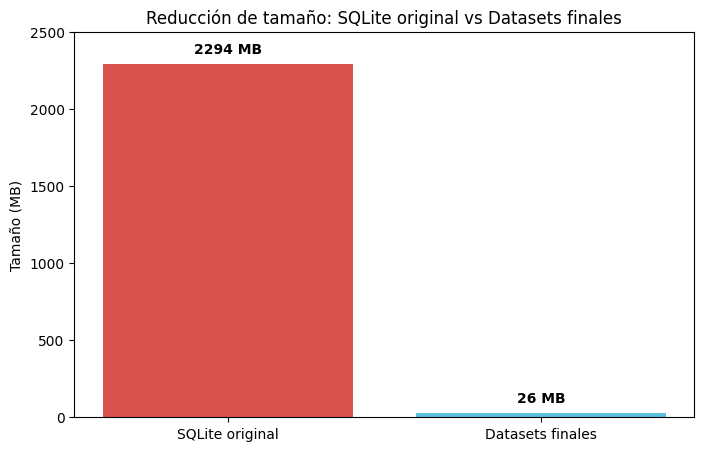

In [40]:
import matplotlib.pyplot as plt

# Datos
sizes_mb = [2294, 26]  # MB
labels = ["SQLite original", "Datasets finales"]

# --- Gráfico de barras ---
plt.figure(figsize=(8,5))
bars = plt.bar(labels, sizes_mb, color=["#d9534f", "#5bc0de"])
plt.ylabel("Tamaño (MB)")
plt.title("Reducción de tamaño: SQLite original vs Datasets finales")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{yval} MB",
             ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.ylim(0, 2500)
plt.show()
